In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
from scipy.optimize import minimize

In [68]:
# The following is a simple example of how to use the ELBO function basing on https://rstudio-pubs-static.s3.amazonaws.com/630126_c2063706da044eb6a2944d7027dcce4d.html
# There is open source code for the ELBO function using python at https://pyro.ai/examples/svi_part_i.html

In [69]:
"""
x is a vector of observed data
z is a vector of latent variables
returns the log likelihood of the data given the latent variables
in this case, the log likelihood is the log probability mass function of a binomial distribution
The pruned binomial distribution is used to avoid numerical issues with the log likelihood
"""

def log_likelihood(x,z):
    val = stats.norm.logpdf(x = np.repeat(x,z.shape[0]),loc=0,scale=np.sqrt(np.tile(z, x.shape[0])))
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val
log_likelihood(np.array([0,0,0]),np.array([1,2,3]))

array([-0.91893853, -1.26551212, -1.46824468, -0.91893853, -1.26551212,
       -1.46824468, -0.91893853, -1.26551212, -1.46824468])

In [70]:
"""z is a vector of latent variables
returns the log prior of the latent variables
in this case, the log prior is the log probability density function of a beta distribution
The pruned beta distribution is used to avoid numerical issues
The initial values of the beta distribution are set to 10,10"""

def log_prior(z):
    phi = 30
    val = stats.invgamma.logpdf(z, a=phi, loc=0, scale=phi)
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val

In [71]:
"""z is a vector of latent variables
phi is a vector of variational parameters
returns the log variational distribution of the latent variables
in this case, the log variational distribution is the log probability density function of a beta distribution
The pruned beta distribution is used to avoid numerical issues"""
def log_variational(z, phi):

    val = stats.invgamma.logpdf(z, a=0.5*phi[0], loc=0, scale=0.5*phi[0])
    val[np.isinf(val) & (val < 0)] = -10000
    val[np.isinf(val) & (val > 0)] = 10000
    return val

In [76]:
"""phi is a vector of variational parameters
x is a vector of observed data
n_samples is the number of samples used to approximate the expectation
returns the simulated ELBO value
I changed the function to use the same seed for the random number generator to make the results reproducible
Also, I vectorized the code to make it faster"""


def ELBO(phi, x, n_samples=10000):

    # np.random.seed(20230125)
    sum = 0
    # simulates z
    z = stats.invgamma.rvs(a=0.5*phi[0], scale=0.5*phi[0], size=n_samples)

    # sum of log likelihoods
    sum_log_lik = np.sum(log_likelihood(x, z))

    # log prior
    log_pr = np.sum(log_prior(z))

    # log variational
    log_var = np.sum(log_variational(z, phi))
    sum += sum_log_lik + log_pr - log_var

    # average (approximates expectation)
    return sum / n_samples


"""phi is a vector of variational parameters
x is a vector of observed data
n_samples is the number of samples used to approximate the expectation
returns the negative ELBO value"""

def neg_ELBO(phi, x, n_samples=10000):
    return -ELBO(phi, x, n_samples)

In [77]:
def optim_ELBO(phi0, x_sample, n_samples):
    bounds = [(0.00001, 1000)]
    result = minimize(neg_ELBO, phi0, args=(x_sample, n_samples), bounds=bounds, method='L-BFGS-B')
    return result

In [78]:
def plot_posterior(phi_opt, true_df, n_tos,plot_ax,x_sample):
    x = np.linspace(0, 1, 100)
    y = stats.invgamma.pdf(x, a=0.5 * phi_opt[0], scale=0.5 * phi_opt[0]) 
    plot_ax.plot(x, y, 'r-', lw=2, label='Posterior Distribution')
    plot_y =  stats.invgamma.pdf(x, a=0.5 * true_df, scale=0.5 * true_df)
    plot_ax.plot(x, plot_y, 'g-', lw=2, label='True Distribution')
    # plot_ax.axvline(true_prob, color='blue', lw=1.6, label='True Probability')
    plot_ax.set_xlabel('z')
    plot_ax.set_ylabel('q(z)')
    plot_ax.set_title(f'With {n_tos} tosses')
    plot_ax.legend()

/Users/zsr/opt/anaconda3/envs/VSC_Python/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3669: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)
/Users/zsr/opt/anaconda3/envs/VSC_Python/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3669: RuntimeWarning: overflow encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)
/Users/zsr/opt/anaconda3/envs/VSC_Python/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:3669: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)


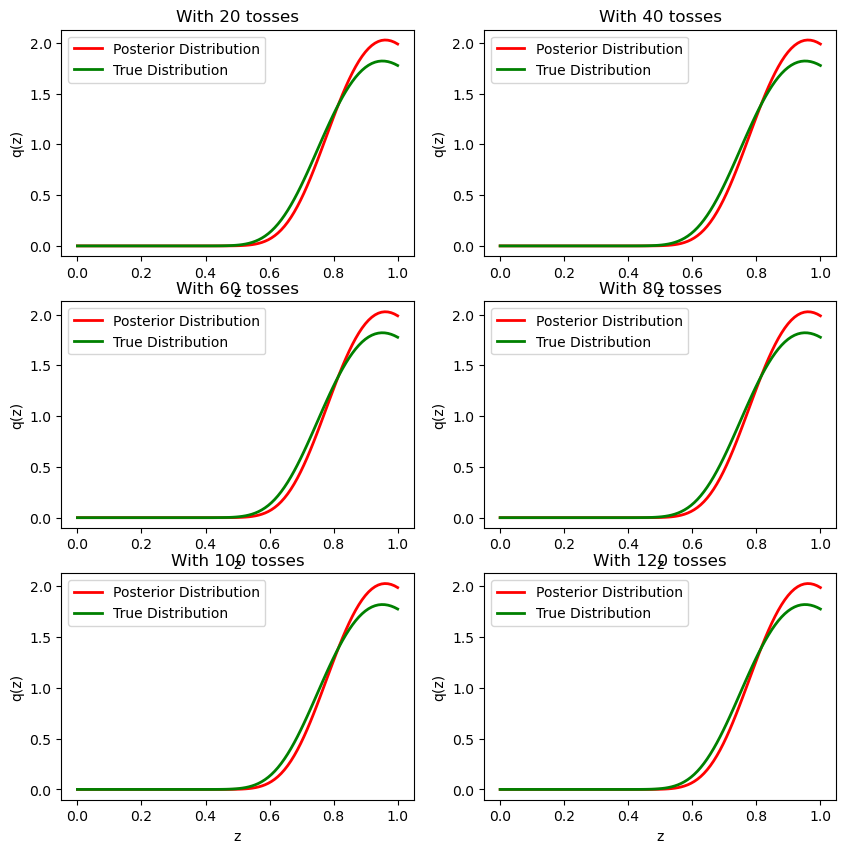

'\nI have tried to use the ELBO function to estimate the posterior distribution of a binomial distribution, but the precision of estimation is limited by the prior function. When the true_prob is close to 0.5 (like 0.6), the overall performance is great.\nBut when the true_prob is close to 0 or 1, the estimation is not good. I think the reason is that the prior function is not good enough to capture the posterior distribution.\n'

In [83]:
#True probability of heads
true_df = 40

#Initial values for alpha and beta
phi0 = [50]


#Number of samples from 
#the variational distribution
n_samples = 2000

#Number of tosses
n_tos = 100

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
to_plot = []
for i, ax in zip(range(20, 140, 20), axs):
    x_sample = stats.t.rvs(df=true_df, size=i)

    phi_opt = optim_ELBO(phi0, x_sample, n_samples)

    plot_posterior(phi_opt.x, true_df, i, ax,x_sample)
plt.show()


"""
I have tried to use the ELBO function to estimate the posterior distribution of a binomial distribution, but the precision of estimation is limited by the prior function. When the true_prob is close to 0.5 (like 0.6), the overall performance is great.
But when the true_prob is close to 0 or 1, the estimation is not good. I think the reason is that the prior function is not good enough to capture the posterior distribution.
"""

In [ ]:
[np.sum(x_sample)+1, n_tos - np.sum(x_sample)+1]

[50, 52]

In [ ]:
phi_opt.x

array([ 58.54296898, 159.18374372])